In [1]:
import json
import urllib.request
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tv_df = pd.read_pickle(r'E:\entrevistas\dataset\tv_final.pkl')

# Feature enginering

In [3]:
from datetime import datetime
from dateutil.relativedelta import relativedelta


def date(row):
    s_registration_timestamp = pd.Timestamp(row['seller_registration_date']).tz_convert(None)
    row['seller_registration_year'] = s_registration_timestamp.year
    row['seller_registration_month'] = s_registration_timestamp.month
    row['seller_registration_day'] = s_registration_timestamp.month
    
    now = datetime.now()
    end_date = datetime.fromtimestamp(datetime.now().timestamp())
    try:
        #if timestamp is none
        start_date = datetime.fromtimestamp(s_registration_timestamp.timestamp())
        
        difference_in_years = relativedelta(end_date, start_date).years
        difference_in_months = relativedelta(end_date, start_date).months
        #difference_in_days = relativedelta(end_date, start_date).days

        month_diff = difference_in_years * 12 + difference_in_months

        row['seller_years_active'] = difference_in_years
        row['seller_months_active'] = month_diff

        time_diff = now - s_registration_timestamp
        row['seller_days_active'] = time_diff.days
    
    except:
        #all nan
        row['seller_years_active'] = s_registration_timestamp.year
        row['seller_months_active'] = s_registration_timestamp.year
        row['seller_days_active'] = s_registration_timestamp.year
        
        
    
    
    
    item_pub_startt = pd.Timestamp(row['publication_start_time']).tz_convert(None)
    row['item_publication_year'] = item_pub_startt.year
    row['item_publication_month'] = item_pub_startt.month
    row['item_publication_day'] = item_pub_startt.month

    try:
        #if timestamp is none
        start_date = datetime.fromtimestamp(item_pub_startt.timestamp())

        difference_in_years = relativedelta(end_date, start_date).years
        difference_in_months = relativedelta(end_date, start_date).months
        #difference_in_days = relativedelta(end_date, start_date).days

        month_diff = difference_in_years * 12 + difference_in_months

        row['item_years_published'] = difference_in_years
        row['item_months_published'] = month_diff

        time_diff = now - item_pub_startt
        row['item_days_published'] = time_diff.days

    except:
        #all nan
        row['item_years_published'] = item_pub_startt.year
        row['item_months_published'] = item_pub_startt.year
        row['item_days_published'] = item_pub_startt.year

    return row
    
tv_df = tv_df.apply(date, axis=1)

In [4]:
tv_df = tv_df.reset_index(drop=True)

# Feature extraction

In [5]:
#pipeline dependencies
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import confusion_matrix, accuracy_score

import xgboost as xgb

In [6]:
class GetDummies2(BaseEstimator, TransformerMixin):
       
    def __init__(self):
        self.enc = None
        
    def fit(self, X, y=None):
        self.enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

        self.enc.fit(X)
        
            
        return self
    
    def transform(self, X):
        out = self.enc.transform(X)
        self.categorical_dimension = out.shape[1]
        
        return pd.DataFrame(out)
    
    def get_categorical_dimension(self):
        return self.categorical_dimension

In [7]:
"""
other_attribbutes = ['id', 'site_id', 'title', 'price', 'sold_quantity', 'seller.seller_reputation.transactions.completed',
          'latitude', 'longitude', 'discount', 'seller_years_active', 'seller_months_active', 'seller_days_active',
           'item_months_published', 'item_days_published', 'item_initial_quantity']

cat_attribbutes = ['condition', 'seller.seller_reputation.power_seller_status', 
          'seller.seller_reputation.level_id', 'address.state_name', 'shipping.mode', 
          'available_quantity', 'item_years_published', 'DISPLAY_SIZE', 'DISPLAY_TYPE', 'IS_SMART', 'RESOLUTION_TYPE', 'brand']#'listing_type_id', 


for cat in cat_attribbutes:
    tv_df[cat].fillna('other', inplace=True)
    
get_dummies = GetDummies2()
categorical = get_dummies.fit_transform(tv_df[cat_features].values)
categorical_dimension = get_dummies.get_categorical_dimension()
tv_categorical = pd.concat([tv_df[other_attribbutes], categorical ], axis=1)

"""


other_attribbutes = ['id', 'site_id', 'title', 'sold_quantity', 
                     'price', 'seller.seller_reputation.transactions.completed', 
                     'discount', 'item_initial_quantity', 'latitude', 'longitude']

cat_attribbutes = ['condition', 'seller.seller_reputation.power_seller_status', 
                  'seller.seller_reputation.level_id', 'address.state_name', 
                   'shipping.mode', 'brand']#'listing_type_id', 


ord_attribbutes = ['available_quantity', 'DISPLAY_SIZE', 'item_months_published', 'seller_years_active']



for cat in cat_attribbutes:
    tv_df[cat].fillna('other', inplace=True)
    
for cat in ord_attribbutes:
    tv_df[cat].fillna(0, inplace=True)

tv_df = tv_df.astype({"seller_years_active": int})
get_dummies = GetDummies2()
categorical = get_dummies.fit_transform(tv_df[cat_attribbutes + ord_attribbutes].values)
categorical_dimension = get_dummies.get_categorical_dimension()
tv_categorical = pd.concat([tv_df[other_attribbutes], categorical ], axis=1)

In [8]:
#spliteo estratificadamente en base al sold quantity
def split_train_test(dataset, split_ratio, seed, efective_sample = 30):
    
    
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()
    
    #sampleo estratificado por sold quantity para garantizar la existencia dee muestras de todos  los grupos
    for cat in dataset.sold_quantity.unique():
        stratum = dataset[dataset['sold_quantity'] == cat].copy()
        
        #sampleo una cantidad determinada para que quede balanceeado, ya  que existe un desbalance importantre entre grupos
        #efective_sample = frac * total => frac = efective_sample / total
        if stratum.shape[0] > efective_sample:
            frac = efective_sample / stratum.shape[0]
        else:
            #si hay meenos muestras que efective_sample, entonces considero todo
            frac = 1 
            
        stratum = stratum.sample(frac=frac, random_state=1) 
        stratum = stratum.reset_index(drop=True)
        
        #mezclo los  indices y separo en train y test
        shuffled_indices = np.random.RandomState(seed=seed).permutation(len(stratum))
        train_set_size = int(len(stratum) * split_ratio)
        train_indices = shuffled_indices[:train_set_size]
        test_indices = shuffled_indices[train_set_size:]
        
        train_stratum = stratum.iloc[train_indices]
        test_stratum = stratum.iloc[test_indices]
        
        train_set = pd.concat([train_set, train_stratum], ignore_index=True)
        test_set = pd.concat([test_set, test_stratum], ignore_index=True)
        
    return train_set, test_set

In [9]:
#check balance
tv_categorical.sold_quantity.value_counts()

0.0      11572
5.0        619
1.0        451
2.0        219
3.0        188
25.0        96
4.0         84
50.0        65
100.0       51
500.0       27
250.0       19
150.0       18
200.0       17
Name: sold_quantity, dtype: int64

In [10]:
train_set_cat, test_set_cat = split_train_test(tv_categorical, 0.8, 42, efective_sample = 450)

In [11]:
class NumericalCategoricalSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, feature_dimension):
        self.attribute_names = attribute_names
        self.feature_dimension = feature_dimension
        
    def fit(self, X, y=None):
        if 'latitude' in self.attribute_names:
            self.lat_median = X['latitude'].median()
            self.lon_median = X['longitude'].median()
            
        return self
    
    def transform(self, X):
        if 'latitude' in self.attribute_names:
            
            X['latitude'].fillna(self.lat_median, inplace=True)
            X['longitude'].fillna(self.lon_median, inplace=True)
                
            return X[self.attribute_names].values
        
        else:
            return X.iloc[:,-self.feature_dimension:].values


In [12]:
"""
num_features = ['price', 'seller.seller_reputation.transactions.completed', 'discount', 'seller_years_active', 'item_days_published', 'item_initial_quantity']

cat_features = ['condition', 'seller.seller_reputation.power_seller_status', 
          'seller.seller_reputation.level_id', 'address.state_name', 'shipping.mode', 
          'available_quantity', 'item_years_published', 'DISPLAY_SIZE', 'DISPLAY_TYPE', 'IS_SMART', 'RESOLUTION_TYPE', 'brand']#, 'address.city_name', 'brand']

"""
num_features = ['price', 'seller.seller_reputation.transactions.completed', 'discount', 'item_initial_quantity', 'latitude', 'longitude']
#num_features = ['log_price', 'seller.seller_reputation.transactions.completed', 'discount', 'item_initial_quantity']

cat_features = ['condition', 'seller.seller_reputation.power_seller_status', 
          'seller.seller_reputation.level_id', 'address.state_name', 'shipping.mode', 
          'available_quantity', 'item_years_published', 'seller_years_active', 
          'DISPLAY_SIZE', 'DISPLAY_TYPE', 'IS_SMART', 'RESOLUTION_TYPE', 'brand']




In [13]:
num_pipeline = Pipeline([
    ('selector', NumericalCategoricalSelector(num_features, len(num_features))),
    ('imputer', SimpleImputer(strategy='constant', fill_value = 0)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', NumericalCategoricalSelector(cat_features, categorical_dimension)),
    
    
])

full_pipeline  = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [14]:
labels = train_set_cat['sold_quantity'].copy()
labels_test = test_set_cat['sold_quantity'].copy()

In [15]:
data_train = full_pipeline.fit_transform(train_set_cat)
data_test = full_pipeline.transform(test_set_cat)

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

label = enc.fit_transform(np.array(labels).reshape(-1, 1))
label_test = enc.transform(np.array(labels_test).reshape(-1, 1))

# XGBoost

**Entrenamos un modelo XGboost sobre la lista de features para luego calcular la importancia de estos y 
hacer una seleccion de un subconjunto para luego entrenar el modelo definitivo.**

**Lo que buscamos con esto es eliminar aquellos features que puedan llegar a meter ruido como tambien reducir las dimensiones y 
asi acelerar los tiempos**

In [16]:
y = tv_categorical['sold_quantity'].copy()
X = full_pipeline.transform(tv_categorical)

In [17]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [18]:
xg_cls = xgb.XGBClassifier(objective ='multi:softmax', n_jobs = -1)

In [19]:
xg_cls.fit(data_train,labels)

xgb_preds = xg_cls.predict(data_test)

In [20]:
conf_matrix = confusion_matrix(labels_test, xgb_preds)
acc = accuracy_score(labels_test, xgb_preds)
acc

0.8468677494199536

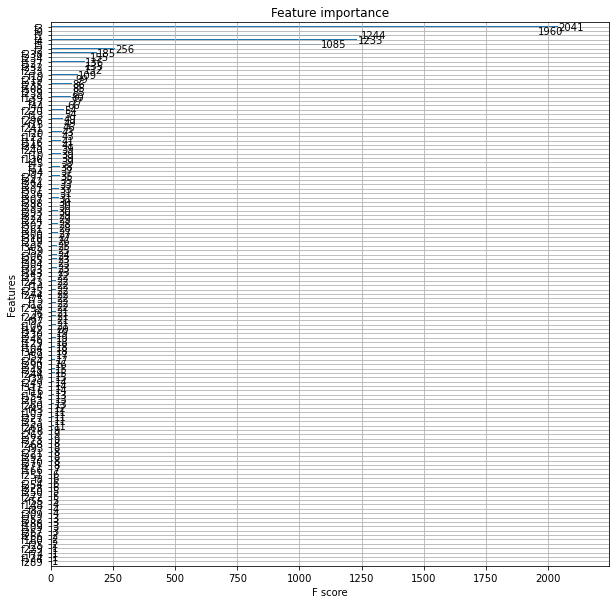

In [23]:
xgb.plot_importance(xg_cls)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [24]:
feature_importance = xg_cls.get_booster().get_score(importance_type= 'gain')

In [25]:
{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

{'f289': 65.2720108,
 'f309': 11.2007604475,
 'f292': 8.424157866875001,
 'f270': 8.029888410125,
 'f271': 7.533808782875,
 'f267': 7.4069112200000005,
 'f264': 6.472591540470588,
 'f75': 5.8201773166363635,
 'f290': 4.408135950293749,
 'f273': 3.913574907444444,
 'f288': 3.877533873333333,
 'f308': 3.4453025652222227,
 'f260': 3.326788751815384,
 'f272': 3.1257106182000003,
 'f16': 3.120598550171429,
 'f263': 2.7768116734615385,
 'f39': 2.7627557781653334,
 'f307': 2.727590422354839,
 'f3': 2.7106854107178986,
 'f261': 2.6302124647607146,
 'f222': 2.2144337280000004,
 'f228': 2.170204043,
 'f266': 2.097850325,
 'f104': 1.6302013514833333,
 'f306': 1.5759047695333332,
 'f139': 1.5347524206387495,
 'f295': 1.5181882672366664,
 'f109': 1.4978195923333335,
 'f12': 1.475070977048182,
 'f97': 1.4649123899619048,
 'f299': 1.4299182740727274,
 'f219': 1.3874911189391916,
 'f238': 1.3633742806482156,
 'f130': 1.3616080639538464,
 'f25': 1.335365295,
 'f87': 1.3089601235,
 'f106': 1.28372968579

In [26]:
from sklearn.feature_selection import SelectFromModel
selection = SelectFromModel(xg_cls, threshold=0.002, prefit=True)#0.002
selected_dataset = selection.transform(data_train)
selected_dataset_test = selection.transform(data_test)

**SelectFromModel nos permite extraer los features mas significativos dado un umbral. Seria la ultima etapa del pipeline.
Una vez fiteado el modelo XGBoost utilizado para seleccionar los features, se pasa como argumento a SelectFromModel**

In [27]:
selected_dataset.shape

(1703, 93)

# Modelo Final

## Feature Selection

In [29]:
from sklearn.ensemble import RandomForestClassifier
forest_cls = RandomForestClassifier(n_jobs = -1)#, n_estimators = 5)# , max_depth = 200 , random_state=0)
forest_cls.fit(selected_dataset, label)

RandomForestClassifier(n_jobs=-1)

In [30]:
tree_pred_test = forest_cls.predict(selected_dataset_test)

In [31]:
conf_matrix = confusion_matrix(label_test.argmax(axis=1), tree_pred_test.argmax(axis=1))
acc = accuracy_score(label_test.argmax(axis=1), tree_pred_test.argmax(axis=1))

print('Acccuracy: ', acc)

Acccuracy:  0.8236658932714617


## No Feature Selection

In [32]:
from sklearn.ensemble import RandomForestClassifier
forest_cls_nosel = RandomForestClassifier(n_jobs = -1)#, n_estimators = 5)# , max_depth = 200 , random_state=0)
forest_cls_nosel.fit(data_train, label)

RandomForestClassifier(n_jobs=-1)

In [33]:
tree_pred_test_nosel = forest_cls_nosel.predict(data_test)

In [34]:
conf_matrix = confusion_matrix(label_test.argmax(axis=1), tree_pred_test_nosel.argmax(axis=1))
acc = accuracy_score(label_test.argmax(axis=1), tree_pred_test_nosel.argmax(axis=1))


print('Acccuracy: ', acc)

Acccuracy:  0.8074245939675174
